# 1. Load the dataset

We will use a benign dataest `Pre_train_D_0.csv`.

In [1]:
import pandas as pd

def load_dataset(path):
    # parse the dataset
    df = pd.read_csv(path)

    ################ distilled from notebook 0 ################
    # check the integrity
    assert df.isna().any().any() == False, 'There is at least one missing value.'
    assert df['Timestamp'].is_monotonic_increasing, 'Timestamp is not sorted.'

    # type-cast
    df['abstime'] = pd.to_datetime(df['Timestamp'], unit='s').round('us')
    df['monotime'] = df['Timestamp'] - df['Timestamp'].min()
    df['aid_int'] = df['Arbitration_ID'].map(lambda x: int(x, 16))
    df['y'] = df['Class'].map({'Normal': 0, 'Attack': 1})

    return df


df = load_dataset('0_Preliminary/0_Training/Pre_train_D_0.csv')
df

,Timestamp,Arbitration_ID,DLC,Data,Class,abstime,monotime,aid_int,y
0,1.597708e+09,260,8,06 25 05 30 FF CF 71 55,Normal,2020-08-17 23:43:47.052591,0.000000,608,0
1,1.597708e+09,329,8,4A C5 7E 8C 31 2D 01 10,Normal,2020-08-17 23:43:47.053980,0.001389,809,0
2,1.597708e+09,38D,8,00 00 49 00 90 7F FE 01,Normal,2020-08-17 23:43:47.054670,0.002079,909,0
3,1.597708e+09,420,8,50 1E 00 C8 FC 4F 6A 00,Normal,2020-08-17 23:43:47.054904,0.002313,1056,0
4,1.597708e+09,421,8,FE 07 00 FF E3 7F 00 52,Normal,2020-08-17 23:43:47.055140,0.002549,1057,0
...,...,...,...,...,...,...,...,...,...
179341,1.597708e+09,391,8,00 00 00 00 00 00 08 EB,Normal,2020-08-17 23:45:01.706675,74.654084,913,0
179342,1.597708e+09,260,8,06 39 1A 30 FF D1 A1 63,Normal,2020-08-17 23:45:01.706905,74.654314,608,0
179343,1.597708e+09,421,8,FE 07 00 FF E3 7F 00 9E,Normal,2020-08-17 23:45:01.707144,74.654553,1057,0
179344,1.597708e+09,130,8,94 8E F0 81 00 00 0B AC,Normal,2020-08-17 23:45:01.707378,74.654787,304,0


# 2. Data exploration


## Number of Arbitration IDs

In [2]:
df['Arbitration_ID'].nunique()

73

## List of Arbitration IDs

In [3]:
df['Arbitration_ID'].unique()
# sorted(df['Arbitration_ID'].unique())

array(['260', '329', '38D', '420', '421', '153', '220', '340', '389',
       '47F', '130', '140', '251', '2B0', '164', '356', '366', '367',
       '368', '381', '387', '394', '453', '470', '490', '495', '500',
       '391', '4F1', '484', '386', '479', '436', '541', '485', '492',
       '4C9', '48A', '58B', '48C', '544', '553', '50C', '52A', '507',
       '5B0', '5CD', '44E', '520', '49F', '572', '483', '50A', '559',
       '410', '412', '50E', '563', '568', '42D', '53E', '4CB', '53B',
       '5A6', '4A9', '53F', '593', '043', '4A7', '4A2', '5BE', '07F',
       '57F'], dtype=object)

## Number of messages

In [4]:
len(df)
df.shape[0]

179346

## Observation period

In [5]:
df['Timestamp'].max() - df['Timestamp'].min()

74.65505194664001

## Number of CAN messages in each ECU

In [6]:
df['Arbitration_ID'].value_counts()

260    7466
153    7466
220    7466
251    7465
367    7465
       ... 
5B0      75
043      75
5BE      74
07F      74
57F      37
Name: Arbitration_ID, Length: 73, dtype: int64

## Count the ground-truth

In [7]:
df['y'].value_counts()

0    179346
Name: y, dtype: int64

## The number of messages per second

$n=\frac{\text{Number of messages}}{\text{Capture period}}$

In [8]:
n = df.shape[0] / (df['Timestamp'].max() - df['Timestamp'].min())
f'There are {n:.02f} CAN messages per second on average.'

'There are 2402.33 CAN messages per second on average.'

# 3. ECU-wise time interval measurement 

In [9]:
df['td'] = df['Timestamp'].diff() # td stands for timedelta
df

,Timestamp,Arbitration_ID,DLC,Data,Class,abstime,monotime,aid_int,y,td
0,1.597708e+09,260,8,06 25 05 30 FF CF 71 55,Normal,2020-08-17 23:43:47.052591,0.000000,608,0,NaN
1,1.597708e+09,329,8,4A C5 7E 8C 31 2D 01 10,Normal,2020-08-17 23:43:47.053980,0.001389,809,0,0.001389
2,1.597708e+09,38D,8,00 00 49 00 90 7F FE 01,Normal,2020-08-17 23:43:47.054670,0.002079,909,0,0.000690
3,1.597708e+09,420,8,50 1E 00 C8 FC 4F 6A 00,Normal,2020-08-17 23:43:47.054904,0.002313,1056,0,0.000234
4,1.597708e+09,421,8,FE 07 00 FF E3 7F 00 52,Normal,2020-08-17 23:43:47.055140,0.002549,1057,0,0.000236
...,...,...,...,...,...,...,...,...,...,...
179341,1.597708e+09,391,8,00 00 00 00 00 00 08 EB,Normal,2020-08-17 23:45:01.706675,74.654084,913,0,0.000248
179342,1.597708e+09,260,8,06 39 1A 30 FF D1 A1 63,Normal,2020-08-17 23:45:01.706905,74.654314,608,0,0.000230
179343,1.597708e+09,421,8,FE 07 00 FF E3 7F 00 9E,Normal,2020-08-17 23:45:01.707144,74.654553,1057,0,0.000239
179344,1.597708e+09,130,8,94 8E F0 81 00 00 0B AC,Normal,2020-08-17 23:45:01.707378,74.654787,304,0,0.000234


| AID | Timestamp | What we expected | What we got |
|-----|-----------|------------------|-------------|
| 1   | 1         |                  |             |
| 2   | 2         |                  | 1           |
| 3   | 3         |                  | 1           |
| 1   | 4         | 3 (=4-1)         | 1           |
| 1   | 5         | 1 (=5-4)         | 1           |
| 2   | 6         | 4 (=6-2)         | 1           |
| 3   | 7         | 4 (=7-3)         | 1           |


`series.diff()` returns a diff value of adjacent rows. But, it is not what we expected. We need to calculate time intervals of two messages from the same ECU.

## Group by Arbitration ID

A similar concept to keyword `group by` of SQL

In [10]:
gb = df.groupby('Arbitration_ID')
gb  # a group-by operator; not a data unless further operaters are given.

In [11]:
gb.size()  # equals to df['Arbitration_ID'].value_counts()

Arbitration_ID
043      75
07F      74
130    7461
140    7461
153    7466
       ... 
593     373
5A6     373
5B0      75
5BE      74
5CD     374
Length: 73, dtype: int64

In [12]:
df['td'] = gb['Timestamp'].diff() 

In [13]:
df.loc[:40]

,Timestamp,Arbitration_ID,DLC,Data,Class,abstime,monotime,aid_int,y,td
0,1.597708e+09,260,8,06 25 05 30 FF CF 71 55,Normal,2020-08-17 23:43:47.052591,0.000000,608,0,NaN
1,1.597708e+09,329,8,4A C5 7E 8C 31 2D 01 10,Normal,2020-08-17 23:43:47.053980,0.001389,809,0,NaN
2,1.597708e+09,38D,8,00 00 49 00 90 7F FE 01,Normal,2020-08-17 23:43:47.054670,0.002079,909,0,NaN
3,1.597708e+09,420,8,50 1E 00 C8 FC 4F 6A 00,Normal,2020-08-17 23:43:47.054904,0.002313,1056,0,NaN
4,1.597708e+09,421,8,FE 07 00 FF E3 7F 00 52,Normal,2020-08-17 23:43:47.055140,0.002549,1057,0,NaN
5,1.597708e+09,153,8,20 80 10 FF 00 FF A0 4E,Normal,2020-08-17 23:43:47.055378,0.002787,339,0,NaN
6,1.597708e+09,220,8,12 24 7C 00 00 6D 10 F6,Normal,2020-08-17 23:43:47.055615,0.003024,544,0,NaN
7,1.597708e+09,340,8,00 00 00 24 36 01 25 30,Normal,2020-08-17 23:43:47.055853,0.003262,832,0,NaN
8,1.597708e+09,389,8,00 00 00 20 00 00 C2 00,Normal,2020-08-17 23:43:47.056095,0.003504,905,0,NaN
9,1.597708e+09,47F,8,00 EC FF FA 00 78 00 36,Normal,2020-08-17 23:43:47.056338,0.003747,1151,0,NaN


In [14]:
# ECU-wise average time interval
gb['td'].mean()
# gb['Timedelta'].mean().to_dict() # to print entire information

Arbitration_ID
043    0.999216
07F    1.000010
130    0.010006
140    0.010006
153    0.010000
         ...   
593    0.199992
5A6    0.200001
5B0    0.999765
5BE    1.000009
5CD    0.199953
Name: td, Length: 73, dtype: float64

## Visualization of the average time interval

0.01s, 0.02s, 0.05s, 0.1s, 0.2s, 0.5s, 1s, 2s

<AxesSubplot: xlabel='Arbitration_ID'>

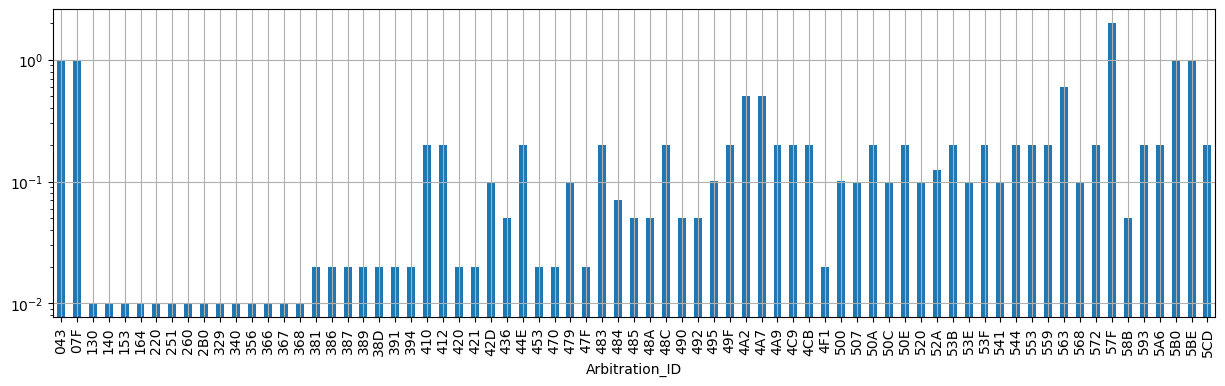

In [15]:
gb['td'].mean().plot(kind='bar', figsize=(15, 4), logy=True, grid=True)

## Time interval distribution

seems to be a gaussian distribution

7461 messages obtained


<AxesSubplot: ylabel='Density'>

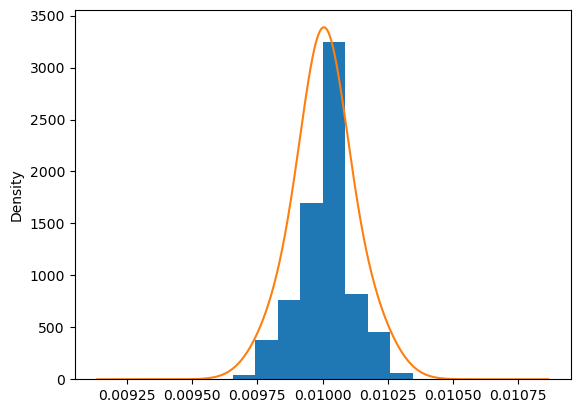

In [16]:
df_query = df.loc[df['Arbitration_ID'] == '130', 'td']
print('{} messages obtained'.format(df_query.shape[0]))

df_query.plot.hist()
df_query.plot.density(bw_method=.8)

## Summary the CAN dataset

In [17]:
df_summary = pd.concat([
    gb.size().rename('Count'),
    gb['DLC'].unique(),
    gb['td'].min().rename('Min td'),
    gb['td'].mean().rename('Avg td'),
    gb['td'].max().rename('Max td'),
    gb['td'].std().rename('Std td'),
    gb['Data'].nunique().rename('Num of uniq. payload'),
], axis=1)  # when axis=1, each series is concatenated as a column. axis=0 for the row-concatenation.

pd.options.display.max_rows = 100  # print 100 rows at once
df_summary

,Count,DLC,Min td,Avg td,Max td,Std td,Num of uniq. payload
Arbitration_ID,,,,,,,
043,75,[8],0.997439,0.999216,1.000019,0.000387,1
07F,74,[8],0.999279,1.000010,1.000974,0.000266,1
130,7461,[8],0.009569,0.010006,0.010433,0.000101,7398
140,7461,[8],0.009566,0.010006,0.010432,0.000102,5146
153,7466,[8],0.009157,0.010000,0.010843,0.000128,15
164,7465,[4],0.009106,0.010000,0.010891,0.000202,16
220,7466,[8],0.008830,0.010000,0.011174,0.000375,7466
251,7465,[8],0.009086,0.010000,0.010898,0.000231,7462
260,7466,[8],0.006791,0.010001,0.012750,0.000806,5473


# Conclusion 

1. ECUs transmit CAN messages periodically.
2. There are 73 AIDs.
3. The average 2402.33 

# (FYI) Example of the payload deserialization

it is not necessary for the time interval or entropy-based IDS.

The first payload: 0E 00 00 00 02 00 0E A6


,monotime,Arbitration_ID,Data,Velocity
126,0.052585,52A,0E 00 00 00 02 00 0E A6,14
372,0.152277,52A,0D 00 00 00 02 00 0D A6,13
464,0.192094,52A,0D 00 00 00 02 00 0D A6,13
558,0.232159,52A,0D 00 00 00 02 00 0D A6,13
610,0.252484,52A,0D 00 00 00 02 00 0D A6,13


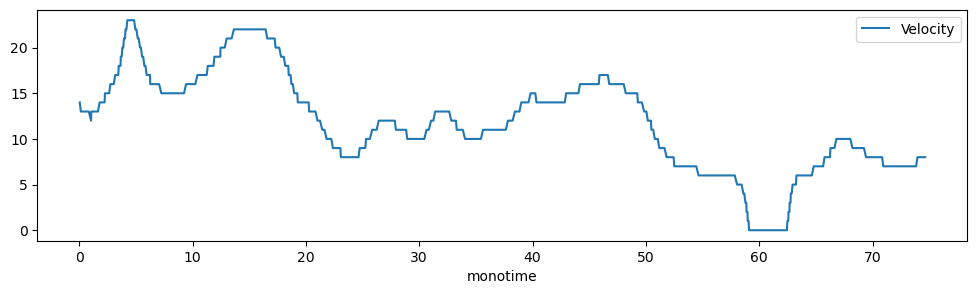

In [19]:
df_clu15 = df.query('aid_int==1322').copy()
print('The first payload:', df_clu15['Data'].iloc[0])
df_clu15['Velocity'] = df_clu15['Data'].map(lambda x: int(x[:2], 16)) # type-cast the first two characters as an int
_ = df_clu15.plot(x='monotime', y='Velocity', figsize=(12, 3))
df_clu15[['monotime', 'Arbitration_ID', 'Data', 'Velocity']].head()